Vision-language models
===

In this notebook we use SkyCLIP, a vision-language model trained on Earth imagery, for text-to-image retrieval and zero-shot classification. 

See [this blog post](https://element84.com/machine-learning/towards-a-queryable-earth-with-vision-language-foundation-models/) on how the text-to-image retrieval functionality can be scaled over large regions to make them queryable with natural language.

<hr style="border: 2px solid gray">

In [ ]:
%env AWS_REQUEST_PAYER=requester
%env AWS_S3_REQUESTER_PAYS=yes

In [ ]:
from rastervision.pipeline.file_system.utils import (download_or_copy,
                                                     list_paths)
from rastervision.core.box import Box
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import torch
from torch.utils.data import ConcatDataset, DataLoader
from shapely.geometry import mapping
import pystac_client
import geopandas as gpd
import contextily as cx
from matplotlib import pyplot as plt

DEVICE = 'cuda'

---

# Load SkyCLIP model

The specific SkyCLIP weights we are using are from the `SkyCLIP_ViT_L14_top50pct` checkpoint listed here: https://github.com/wangzhecheng/SkyScript?tab=readme-ov-file#download-model-checkpoints.

In [ ]:
# !aws s3 cp s3://ml-workshop/vlm/skyclip.pt data/skyclip.pt

In [13]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

In [14]:
ckpt_path = 'data/skyclip.pt'
ckpt = torch.load(ckpt_path, map_location=DEVICE)['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.cuda().eval()

In [15]:
print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


---

# Get imagery

In [3]:
bbox = Box(ymin=39.889060, xmin=-75.104968, ymax=39.989442, xmax=-75.246207)
bbox_polygon = bbox.to_shapely().oriented_envelope
search_geometry = mapping(bbox_polygon)

In [4]:
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

items = catalog.search(
    intersects=search_geometry,
    datetime='2019-10-01/2020-01-01',
    collections=['naip'],
).item_collection()
len(items)

5

In [5]:
gdf = gpd.GeoDataFrame.from_features(items)

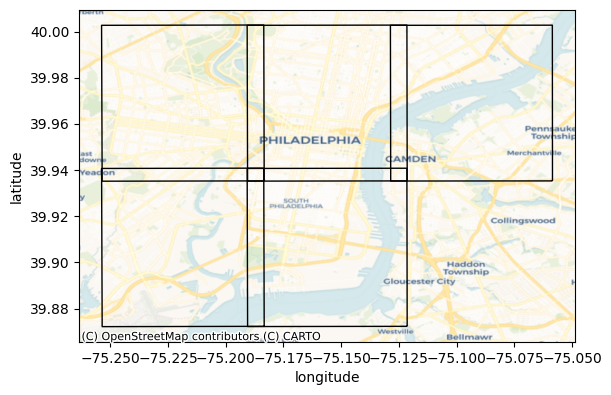

In [9]:
fig, ax = plt.subplots()
gdf.plot(ax=ax, ec='k', fc='none')
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

# Generate vector embeddings

Download GeoTIFFs:

In [ ]:
for item in items:
    download_or_copy(item.assets['image'].href, 'data/naip', delete_tmp=True)

In [9]:
img_uris = list_paths('data/naip', ext='tif')
img_uris

['data/naip/m_3907508_nw_18_060_20191015.tif',
 'data/naip/m_3907507_nw_18_060_20191019.tif',
 'data/naip/m_3907507_ne_18_060_20191015.tif',
 'data/naip/m_3907507_se_18_060_20191015.tif',
 'data/naip/m_3907507_sw_18_060_20191019.tif']

In [10]:
dses = [None] * len(img_uris)
for i, uri in enumerate(img_uris):
    dses[i] = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
        image_uri=uri,
        image_raster_source_kw=dict(channel_order=[0, 1, 2]),
        size=400,
        stride=400,
        out_size=224,
    )
ds = ConcatDataset(dses)
len(ds)

3925

In [11]:
dl = DataLoader(ds, batch_size=16, num_workers=4)

In [16]:
EMBEDDING_DIM_SIZE = 768
embs = torch.zeros(len(ds), EMBEDDING_DIM_SIZE)

with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    i = 0
    for x, _ in bar:
        x = x.to(DEVICE)
        emb = model.encode_image(x)
        embs[i:i + len(x)] = emb.cpu()
        i += len(x)

# normalize the embeddings
embs /= embs.norm(dim=-1, keepdim=True)

embs.shape

Creating chip embeddings:   0%|          | 0/246 [00:00<?, ?it/s]

torch.Size([3925, 768])

In [18]:
embs_path = 'data/skyclip_naip_embeddings.pt'
torch.save(embs, embs_path)

In [ ]:
# !aws s3 cp {embs_path} s3://ml-workshop-internal/2024_05_02/<YOUR NAME>/skyclip_naip_embeddings.pt

# Text-to-image retrieval

In [17]:
windows = sum((_ds.windows for _ds in ds.datasets), [])
len(windows)

3925

In [18]:
def get_chip_scores(text_queries, embs):
    assert len(text_queries) == 1
    text = tokenizer(text_queries)
    with torch.inference_mode():
        text_features = model.encode_text(text.to(DEVICE))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu()
        chip_scores = torch.cosine_similarity(text_features, embs)
    return chip_scores


def emb_idx_to_chip(i, windows, out_shape=(400, 400)):
    chip, _ = ds[int(i)]
    chip = chip.permute(1, 2, 0)
    return chip


def show_top_chips(chip_scores,
                   windows_df,
                   top_inds=None,
                   nrows=5,
                   ncols=5,
                   figsize=(12, 12),
                   w_pad=-2.5,
                   h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = emb_idx_to_chip(i, windows_df)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

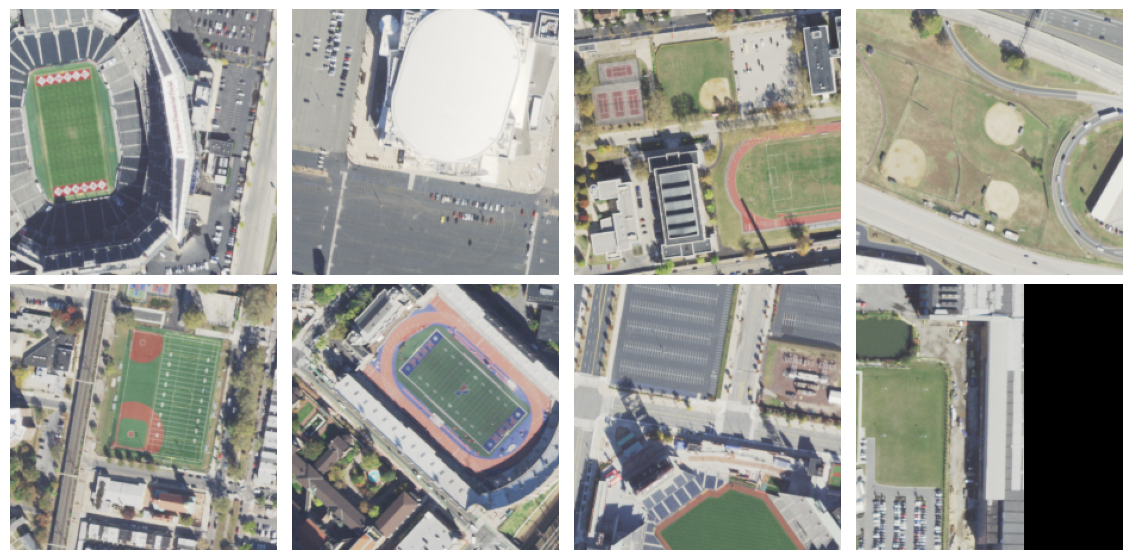

In [19]:
text_query = 'stadium'

chip_scores = get_chip_scores([text_query], embs)
show_top_chips(chip_scores,
               windows,
               nrows=2,
               ncols=4,
               figsize=(12, 6),
               w_pad=-(12 / 4),
               h_pad=-(6 / 4))

# Zero-shot classification

In [20]:
def get_text_scores(text_queries, embs, T):
    assert len(embs) == 1
    text = tokenizer(text_queries)
    with torch.inference_mode():
        text_features = model.encode_text(text.to(DEVICE))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu()
        out = (embs @ text_features.T)
        out = (out / T).softmax(dim=1)
        out = out.numpy().squeeze()
    return out

In [25]:
i = chip_scores.argmax().item()
img, _ = ds[i]
img_emb = embs[[i]]

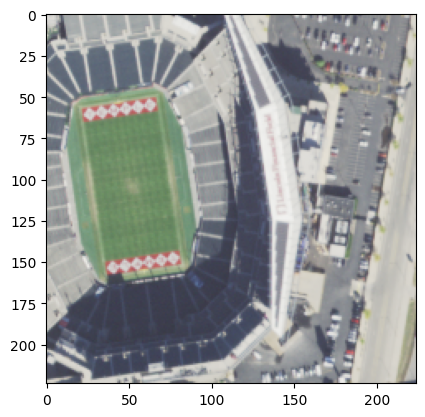

In [26]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [27]:
classes = [
    'forest',
    'harbor',
    'stadium',
    'parking lot',
]

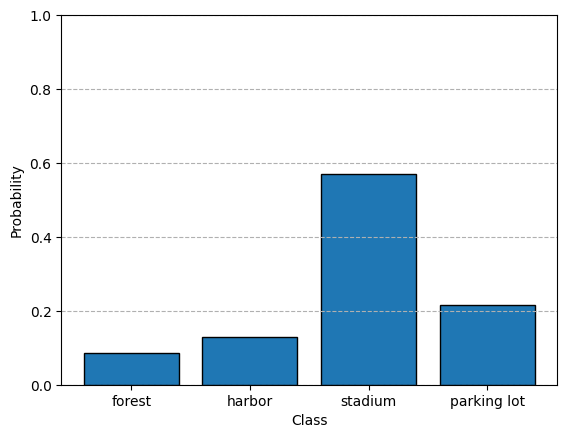

In [28]:
text_scores = get_text_scores(classes, img_emb, T=0.05)

fig, ax = plt.subplots()
ax.bar(classes, text_scores, ec='black')
ax.set_ylim((0, 1))
ax.yaxis.grid(linestyle='--', alpha=1)
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
plt.show()